## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]

In [5]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [6]:
len(signal_dataframe_wrongPV['BDTresponse_wrongPV'])

501573

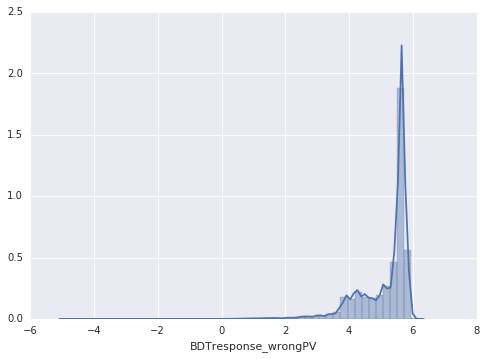

In [7]:
import seaborn as sns
sns.distplot(signal_dataframe_wrongPV['BDTresponse_wrongPV'])

### Function to calculate the FOMs

### Configure  and define cuts 

In [8]:

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

cuttype = 'BDTresponse_wrongPV' 

minimum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].min()
maximum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()
cuts = np.linspace(3.5,3.85,30) #(0,20,10)    #(0,0.001,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [9]:
'''def calculate_foms(data_fit_cut): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    timeres_power = 0
    tagging_power = 0
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)

    
    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(data_fit_cut['Delta_TAU'])) 
    

    ##################################################################
    
    for i in range(data_fit_cut.shape[0]):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
    
        timeres_power     += timeerror_dilution *signal_weight 
        
    timeres_power /= signal_sum

    
    
    fomname_to_value = {
    
        'TimeresPower' : timeres_power,
        'Efficiency'   : efficiency
    }

    return fomname_to_value'''

"def calculate_foms(data_fit_cut): \n    import math\n    \n    signal_sum    = 0\n    cbkg_sum      = 0\n    signal_sumw2  = 0\n    signal_sum    = 0\n    cbkg_sum      = 0\n    signal_sumw2  = 0\n    timeres_power = 0\n    tagging_power = 0\n    \n    signal_sum_tag_decis = 0 # count two ways to check consistency\n    signal_sum_tag_omega = 0\n    \n    delta_m = 5065 \n    S = 0.691 #sin2beta value (average from HFAG)\n\n    \n    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])\n    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])\n    time = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) \n    error = np.absolute(np.array(data_fit_cut['Delta_TAU'])) \n    \n\n    ##################################################################\n    \n    for i in range(data_fit_cut.shape[0]):\n        signal_weight =  1 \n        cbkg_weight   =  1 \n        mistag        =  tagomega[i] \n        tag           =  tag1[i]\n        decaytime     =  time[i]\n        timeerror     =  error[i]

In [10]:
def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    timeres_power_bestPV = 0
    timeres_power_bdt = 0
    

    
    tagomega = np.array(best_pv['B0_TAGOMEGA_OS'])
    tag1 = np.array(best_pv['B0_TAGDECISION_OS'])
    time = np.array(best_pv['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
    
    tagomega_wrong = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1_wrong = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time_wrong = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))
    
    range_best_pv = best_pv.shape[0]-1
    
    for i in range(range_best_pv):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight

        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power_bestPV    += timeerror_dilution*signal_weight
         
    print('+++++++++++++++++++++++++')
    print(cut)
    timeerror_dilution_theory = math.exp(-(delta_m*cut)**2)

    timeres_power_bestPV /= signal_sum
    #timeres_power_wrong /= signal_sum_wrong

    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    
    print("The efficiency of the cut is:")
    print(efficiency)
    
    fomname_to_value = {
        'TimeresPower_bestPV' : timeres_power_bestPV,
        'TimeresTheory': timeerror_dilution_theory,
        'Efficiency'   : efficiency
    }
    #return fomname_to_value

    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong =  1 
        cbkg_weight_wrong   =  1 
        mistag_wrong        =  tagomega_wrong[i] 
        tag_wrong           =  tag1_wrong[i]
        decaytime_wrong     =  time_wrong[i]
        timeerror_wrong     =  error_wrong[i]
        
        
        signal_sum_wrong    += signal_weight_wrong
        signal_sumw2_wrong  += signal_weight_wrong**2
        
        timeerror_dilution_wrong = math.exp(-(delta_m*timeerror_wrong)**2)
    
        timeres_power_bdt     += timeerror_dilution_wrong *signal_weight_wrong 
        
    timeres_power_bdt /= signal_sum_wrong  
    
    fomname_to_value.update({'TimeresPower_bdt' : timeres_power_bdt})
    
    return fomname_to_value

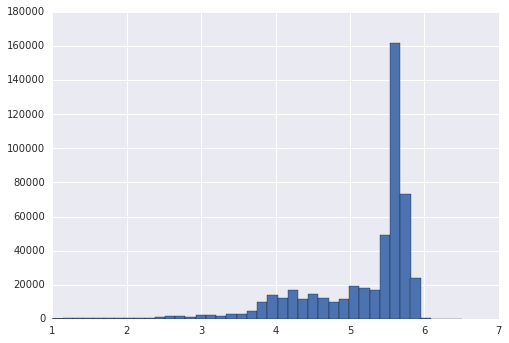

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(signal_dataframe_wrongPV['BDTresponse_wrongPV'],40,range=[1,6.5])
plt.savefig("/home/chasenberg/plots/wrong_pv/bdt_output.pdf")

In [26]:
from ROOT import RooArgList
import subprocess, os
import time
import root_pandas as rp

x=None

data_fit_cut = signal_dataframe_wrongPV.query('BDTresponse_wrongPV>3.5')
data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root',key=tree_mc)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root Bd2JpsiKS "idxRunNumber""'        
subprocess.Popen([my_command], env=my_env, shell=True)
        
print("Wait for GrimReaper")
time.sleep(40.0)        # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root',key=tree_mc)
sig_yields_init = data_fit_cut.shape[0]



Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data


In [27]:
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) 
    best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    print("The inital number of candidates is:")
    print(sig_yields_init)
    print("----------------------------------")
    print("The number of candidates after the cut is:")
    print(sig_yields_cut)
    print("----------------------------------")
    print("The efficiency of the cut is:")
    print(efficiency)
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
    
    
    foms = calculate_foms(data_fit_cut,best_pv)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut BDTresponse_wrongPV>3.5
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
482050
----------------------------------
The number of candidates after the cut is:
482050
----------------------------------
The efficiency of the cut is:
1.0
+++++++++++++++++++++++++
3.5
The efficiency of the cut is:
1.0
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV>3.5120689655172415
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
482050
----------------------------------
The number of candidates after the cut is:
481891
----------------------------------
The efficiency of the cut is:
0.9996701586972305
+++++++++++++++++++++++++
3.51206896552
The efficiency of the cut is:
0.9996701586972305
INFO: Finish Calcu

In [28]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


### Plot FOMs

In [65]:
#calculate poisson uncertainty 
test = pd.DataFrame()
poisson_error_arr = []
for cut in cuts:
    cut = str(cut)
    mu = data_fit_cut.query('BDTresponse_wrongPV>'+cut).shape[0]
    poisson_error = 1/np.sqrt(mu)
    poisson_error_arr.append(poisson_error)
    #return(poisson_error_arr)
poisson_error_arr = poisson_error_arr/np.amax(poisson_error_arr)#*min(np.array(ys['TimeresPower']))
error = np.array(poisson_error_arr)
test['error'] = error

In [66]:

test['TimeresPower'] = np.array(ys['TimeresPower_bdt'])
test['TimeresPower_bestPV'] = np.array(ys['TimeresPower_bestPV'])
test['Efficiency'] = np.array(ys['Efficiency'])

### Get similiar efficiencies for both approaches

#### Import dataframe 

In [67]:
random_df = pd.read_csv('/home/chasenberg/plots/csv_data/random.csv')

In [68]:
test_cut = test.query('Efficiency>0.95')
random_df_cut = random_df.query('Efficiency>0.95')

### Normalize dilution with poisson error

In [69]:
test_cut['TimeresPower_poisson'] = test_cut['TimeresPower'] / test_cut['error']
test_cut['TimeresPower_bestPV_poisson'] = test_cut['TimeresPower_bestPV'] / test_cut['error']
random_df_cut['TimeresPower_randomPV_poisson'] = random_df_cut['TimeresPower_randomPV'] / random_df_cut['error']

In [70]:
'''import seaborn as sns; sns.set_style('white')
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_1 = sns.regplot(x='Efficiency', y='TimeresPower_randomPV',data=random_df_cut,x_estimator=np.mean,fit_reg=True,label="MinIPCHI2 approach") 
plot_2 = sns.regplot(x='Efficiency', y='error',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")
plot_3 = sns.regplot(x='Efficiency', y='TimeresPower',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach")

 
plot_1.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random.pdf")'''

'import seaborn as sns; sns.set_style(\'white\')\nplt.title("")\nplt.xlabel("")\nplt.ylabel("")\n\nplot_1 = sns.regplot(x=\'Efficiency\', y=\'TimeresPower_randomPV\',data=random_df_cut,x_estimator=np.mean,fit_reg=True,label="MinIPCHI2 approach") \nplot_2 = sns.regplot(x=\'Efficiency\', y=\'error\',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")\nplot_3 = sns.regplot(x=\'Efficiency\', y=\'TimeresPower\',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach")\n\n \nplot_1.legend(loc="best")\nplt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random.pdf")'

### Compare BDT approach vs. MinIPCHI2

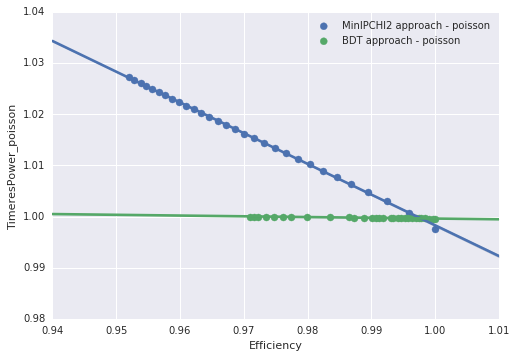

In [71]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plot_1 = sns.regplot(x='Efficiency', y='TimeresPower',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach") 
#plot_2 = sns.regplot(x='Efficiency', y='error',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")
plot_3 = sns.regplot(x='Efficiency', y='TimeresPower_randomPV_poisson',data=random_df_cut,x_estimator=np.mean,fit_reg=True,label="MinIPCHI2 approach - poisson") 
plot_2 = sns.regplot(x='Efficiency', y='TimeresPower_poisson',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach - poisson")

 
plot_2.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random_poisson.pdf")

### Compare BDT approach vs best PV selection

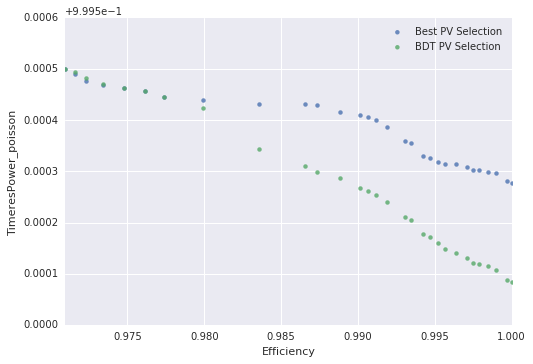

In [74]:
plot_2 = sns.regplot(x='Efficiency', y='TimeresPower_bestPV_poisson',data=test_cut, fit_reg=False,label='Best PV Selection')
plot_1 = sns.regplot(x='Efficiency', y='TimeresPower_poisson',data=test_cut, fit_reg=False,label='BDT PV Selection')
plot_1.legend(loc="best")
plot_1.set(xlim=(test['Efficiency'].min(), test['Efficiency'].max()))
plot_1.set(ylim=(0.9995,1.0001))
plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_bdt_vs_bestpv.pdf")

In [ ]:
a = test['TimeresPower']
plt.plot(cuts,a)
plt.savefig("/home/chasenberg/plots/wrong_pv/timeres _bdt.pdf")

In [ ]:
a = test['Efficiency']
plt.plot(cuts,a)
plt.savefig("/home/chasenberg/plots/wrong_pv/eff_bdt.pdf")